# Completing Bach's famous unfinished fugue
## Linear Regression for time series prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import random
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, log_loss
from scipy import stats
from itertools import islice

Set the seed for reproducing

In [2]:
random.seed(2021)

In [3]:
def bar_chart(X, set_X):
    
    notes = []
    freq = []
    for x in set_X:
        notes.append(str(x))
        freq.append(X.count(x))
    
    N = len(set_X)
    ind = np.arange(N) # the x locations for the groups

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])


    ax.bar(ind, freq, 0.75)

    ax.set_ylabel('Freq')
    ax.set_xlabel('Notes')
    ax.set_title('Frequency by note for a voice')
    plt.xticks(ind, set_X)
    steps = 100
    ax.set_yticks(np.arange(0, max(freq)+steps, steps))
    plt.show()

In [4]:
dat = pd.read_csv("F.txt", sep="\t", header=None)
dat

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
3819,0,0,49,0
3820,0,0,51,0
3821,0,0,51,0
3822,0,0,54,0


Select the voice range (0, 3)

In [5]:
voice = 3

[0, 0, 0, 0, 0, 0, 0, 0, 42, 42]
26 [0, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


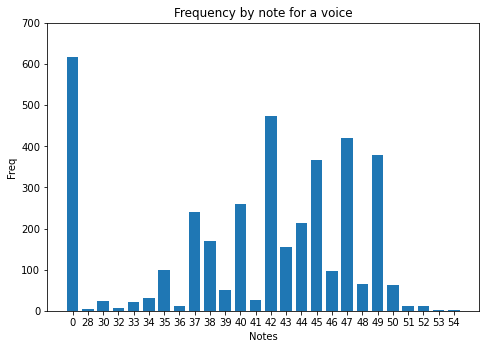

In [6]:
X = list(dat[voice])
print(X[:10])
set_X = list(set(X))
print(len(set_X), set_X)

# frequency per note in the voice
bar_chart(X, set_X)

Get the range, mode, mean probabilities per range for each note in the voice

In [7]:
len_dict = {}
c = 0

for idx, x in enumerate(X):
    if x not in len_dict.keys():
        len_dict[x] = []
    if idx == 0:
        c += 1
    elif x == X[idx-1]:
        c += 1
    else:
        len_dict[X[idx-1]].append(c)
        c = 1
        
for k,v in len_dict.items():
    num = round(np.mean(v))
    if num % 2 != 0:
        num += 1
    d = {}
    for i in v:
        d[i] = round(v.count(i)/len(v), 2)
    len_dict[k] = {"range": v, "mode": stats.mode(v)[0][0], "mean": num, "pd": d}

# example note: 0
print(len_dict[0])

{'range': [8, 48, 4, 16, 48, 208, 4, 4, 4, 4, 4, 14, 4, 4, 4, 16, 4, 4, 160, 4, 4, 4, 4, 4, 4, 20], 'mode': 4, 'mean': 24, 'pd': {8: 0.04, 48: 0.08, 4: 0.65, 16: 0.08, 208: 0.04, 14: 0.04, 160: 0.04, 20: 0.04}}


Convert series of notes of length n to 1

[0, 42, 49, 47, 45, 47, 49, 42, 45, 39]


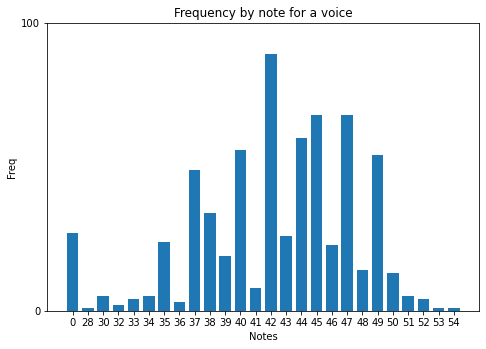

In [8]:
X_one = []

for idx, x in enumerate(X):
    if idx == 0:
        X_one.append(x)
    elif x != X[idx-1]:
        X_one.append(x)

print(X_one[:10])
X = X_one

# frequency per note in the voice after transform
bar_chart(X, set_X)

In [9]:
def to_one_hot(set_X, x):
    n = set_X.index(x)
    return [1 if i==n else 0 for i in range(len(set_X))]

Convert to one-hot vector

In [10]:
X_one = [to_one_hot(set_X, x) for x in X]

Add a sliding window with one-step forecasting

In [11]:
X_t0 = np.array(X_one[:-1])
y_t1 = np.array(X_one[1:])
print(X_t0[1:3])
print(y_t1[:2])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


In [12]:
reg = LinearRegression().fit(X_t0, y_t1)

Sanity check on the last instance

In [13]:
reg.predict([X_t0[-1]])[0]

array([ 8.05664062e-02, -4.77048956e-18,  7.32421875e-04, -2.13623047e-04,
        1.43051147e-06, -9.53674316e-07,  1.66015625e-02,  1.95312500e-03,
        5.46875000e-02,  1.85546875e-02, -3.90625000e-02,  2.69805908e-01,
        3.90625000e-02,  2.34375000e-02,  1.48193359e-01,  1.83593750e-01,
        2.63671875e-02, -4.88281250e-04,  8.98437500e-02,  2.44140625e-04,
        6.56738281e-02,  3.12500000e-02,  4.88281250e-04, -1.83105469e-04,
        3.46944695e-18,  1.60461922e-17])

Get the max probability from the probability output vector, then trace it back to the corresponding note via its index e.g.

In [14]:
yhat = reg.predict([X_t0[49]])
pred = set_X[yhat.tolist()[0].index(max(yhat.tolist()[0]))]
pred

37

Coefficients: 
 [[ 1.92176186e+12  1.92176186e+12  1.92176186e+12  1.92176186e+12
   1.92176186e+12  1.92176186e+12  1.92176186e+12  1.92176186e+12
   1.92176186e+12  1.92176186e+12  1.92176186e+12  1.92176186e+12
   1.92176186e+12  1.92176186e+12  1.92176186e+12  1.92176186e+12
   1.92176186e+12  1.92176186e+12  1.92176186e+12  1.92176186e+12
   1.92176186e+12  1.92176186e+12  1.92176186e+12  1.92176186e+12
   1.92176186e+12  1.92176186e+12]
 [-1.94767125e-03 -1.94767125e-03  1.98052329e-01 -1.94767125e-03
  -1.94767125e-03 -1.94767125e-03 -1.94767125e-03 -1.94767125e-03
  -1.94767125e-03 -1.94767125e-03 -1.94767125e-03 -1.94767125e-03
  -1.94767125e-03 -1.94767125e-03 -1.94767125e-03 -1.94767125e-03
  -1.94767125e-03 -1.94767125e-03 -1.94767125e-03 -1.94767125e-03
  -1.94767125e-03 -1.94767125e-03 -1.94767125e-03 -1.94767125e-03
  -1.94767125e-03 -1.94767125e-03]
 [ 1.39550027e+12  1.39550027e+12  1.39550027e+12  1.39550027e+12
   1.39550027e+12  1.39550027e+12  1.39550027e+12  1.395

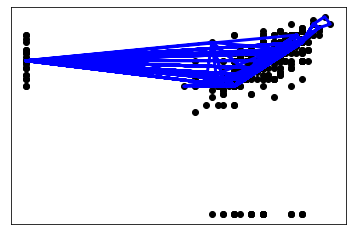

In [15]:
y_pred = [set_X[y.tolist().index(max(y))] for y in reg.predict(X_t0)]
y_test = [set_X[y.tolist().index(max(y))] for y in y_t1]

# The coefficients
print('Coefficients: \n', reg.coef_)

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X[:-1], y_test,  color='black')
plt.plot(X[:-1], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Perform cross-validation for time series

In [16]:
tscv = TimeSeriesSplit()
print(tscv)

for train_index, test_index in tscv.split(X_t0):
    print(f"TRAIN: [{train_index[0]} ... {train_index[-1]}] TEST: [{test_index[0]} ... {test_index[-1]}]")
    X_train, X_test = X_t0[train_index], X_t0[test_index]
    y_train, y_test = y_t1[train_index], y_t1[test_index]

    reg = LinearRegression().fit(X_train, y_train)

    y_pred_vec_train = reg.predict(X_train)
    y_pred_train = [set_X[np.power(_y,3).tolist().index(max(np.power(_y,3)))] for _y in y_pred_vec_train]
    y_train_notes = [set_X[_y.tolist().index(max(_y))] for _y in y_train]
    
    print(
        f"\t#MSE train\t{round(mean_squared_error(y_train_notes, y_pred_train),2)} "
          f"#train log loss\t{round(log_loss(y_train, y_pred_vec_train),2)} "
          f"#train error\t{round(reg.score(X_train, y_train),2)} "
          f"#train acc\t{round(accuracy_score(y_train_notes, y_pred_train),2)} "
          f"#train f1\t{round(f1_score(y_train_notes, y_pred_train, average='macro'), 2)}"
         )
    
    y_pred_vec_test = reg.predict(X_test)
    y_pred_test = [set_X[np.power(_y,3).tolist().index(max(np.power(_y,3)))] for _y in y_pred_vec_test]
    y_test_notes = [set_X[_y.tolist().index(max(_y))] for _y in y_test]

    print(
        f"\t#MSE test\t{round(mean_squared_error(y_test_notes, y_pred_test),2)} "
          f"#test log loss\t{round(log_loss(y_test, y_pred_vec_test),2)} "
          f"#test error\t{round(reg.score(X_test, y_test),2)} "
          f"#test acc\t{round(accuracy_score(y_test_notes, y_pred_test),2)} "
          f"#test f1\t{round(f1_score(y_test_notes, y_pred_test, average='macro'),2)}"
         )

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0 ... 111] TEST: [112 ... 221]
	#MSE train	49.53 #train log loss	1.31 #train error	0.42 #train acc	0.46 #train f1	0.3
	#MSE test	49.85 #test log loss	12.7 #test error	-0.51 #test acc	0.25 #test f1	0.11
TRAIN: [0 ... 221] TEST: [222 ... 331]
	#MSE train	47.92 #train log loss	1.5 #train error	0.34 #train acc	0.39 #train f1	0.21
	#MSE test	51.56 #test log loss	6.31 #test error	0.15 #test acc	0.37 #test f1	0.16
TRAIN: [0 ... 331] TEST: [332 ... 441]
	#MSE train	48.04 #train log loss	1.56 #train error	0.32 #train acc	0.4 #train f1	0.26
	#MSE test	92.74 #test log loss	8.24 #test error	-0.18 #test acc	0.22 #test f1	0.09
TRAIN: [0 ... 441] TEST: [442 ... 551]
	#MSE train	56.42 #train log loss	1.64 #train error	0.21 #train acc	0.37 #train f1	0.25
	#MSE test	77.05 #test log loss	4.02 #test error	0.05 #test acc	0.41 #test f1	0.22
TRAIN: [0 ... 551] TEST: [552 ... 661]
	#MSE train	59.15 #train log loss	1.65 #train error	0.2 #train acc	0.38 #

Save the model to disk, in case we need quick access to it later.

In [ ]:
filename = f"bach_{voice}.sav"
pickle.dump(reg, open(filename, 'wb'))

Predict note in t+1 n times, starting from note in t+0.

In [17]:
preds_vec = np.array([X_t0[-1]])
preds = []
for i in range(100):
    yhat = reg.predict(preds_vec[-1].reshape(1, -1))
    # Pick note, add it
    yhat_dict = dict(zip(set_X, yhat[0].tolist()))
    yhat_dict_sorted = dict(sorted(yhat_dict.items(), key=operator.itemgetter(1),reverse=True))
    top_n = list(islice(yhat_dict_sorted.items(), 10))
    p = random.choice(top_n)[0]
    preds.append(p)
    np.concatenate((preds_vec, [to_one_hot(set_X, p)]))
set(preds), preds[:10]

({0, 37, 40, 41, 43, 44, 45, 47, 49, 50},
 [37, 45, 0, 49, 40, 41, 41, 50, 44, 47])

Prolong/add range to the generated notes using a random weighted choice of all the ranges of that note present in the voice.

In [18]:
output = []
for p in preds:
    # Weighted choice
    range_n = [p] * random.choice(len_dict[p]["range"]) * 2
    output.extend(range_n)
len(output), output[:10]

(1460, [37, 37, 37, 37, 37, 37, 37, 37, 45, 45])

In [19]:
df = pd.DataFrame(output)
df

,0
0,37
1,37
2,37
3,37
4,37
...,...
1455,43
1456,43
1457,43
1458,43


Save the generated notes to a text file in csv format.

In [ ]:
f = f"F_{voice}.txt"
df.to_csv(f, sep="\t", header=None, index=None)